In [1]:
import pandas as pd
import numpy as np
import requests
import json

In [2]:
response = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=demo')
response = response.json()['Time Series (5min)']

In [3]:
with open('data.json', 'w') as file:
    json.dump(response, file)

In [4]:
atr_period = 7
multiplier = 3

In [5]:
data = pd.read_json('data.json').transpose()
data.reset_index(level=0, inplace=True)
data.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
data['Volume'] = data['Volume'].astype(np.int64)

In [6]:
data = data[::-1]
data.reset_index(level=0, inplace=True)
data = data.drop(['index'], axis=1)
df = data.copy()

In [7]:
def atr(DF,n):
    df=DF.copy()
    df['High-Low']=abs(df['High']-df['Low'])
    df['High-PreviousClose']=abs(df['High']-df['Close'].shift(1))
    df['Low-PreviousClose']=abs(df['Low']-df["Close"].shift(1))
    df['TrueRange']=df[['High-Low','High-PreviousClose','Low-PreviousClose']].max(axis=1,skipna=False)
    df['ATR']=df['TrueRange'].ewm(com=n,min_periods=n).mean()
    return df['ATR']


df['ATR']=atr(df,atr_period)

In [8]:
def supertrend(DF,n,m):
    df = DF.copy()
    df['ATR'] = atr(df,n)
    df["BASIC_UPPERBAND"]=((df['High']+df['Low'])/2) + m*df['ATR'] 
    df["BASIC_LOWERBAND"]=((df['High']+df['Low'])/2) - m*df['ATR']
    df["FINAL_UPPERBAND"]=df["BASIC_UPPERBAND"]
    df["FINAL_LOWERBAND"]=df["BASIC_LOWERBAND"]
    ind = df.index
    for i in range(n,len(df)):
        if df['Close'][i-1]<=df['FINAL_UPPERBAND'][i-1]:
            df.loc[ind[i],'FINAL_UPPERBAND']=min(df['BASIC_UPPERBAND'][i],df['FINAL_UPPERBAND'][i-1])
        else:
            df.loc[ind[i],'FINAL_UPPERBAND']=df['BASIC_UPPERBAND'][i]    
    for i in range(n,len(df)):
        if df['Close'][i-1]>=df['FINAL_LOWERBAND'][i-1]:
            df.loc[ind[i],'FINAL_LOWERBAND']=max(df['BASIC_LOWERBAND'][i],df['FINAL_LOWERBAND'][i-1])
        else:
            df.loc[ind[i],'FINAL_LOWERBAND']=df['BASIC_LOWERBAND'][i]  
    df['Strend']=np.nan
    for test in range(n,len(df)):
        if df['Close'][test-1]<=df['FINAL_UPPERBAND'][test-1] and df['Close'][test]>df['FINAL_UPPERBAND'][test]:
            df.loc[ind[test],'Strend']=df['FINAL_LOWERBAND'][test]
            break
        if df['Close'][test-1]>=df['FINAL_LOWERBAND'][test-1] and df['Close'][test]<df['FINAL_LOWERBAND'][test]:
            df.loc[ind[test],'Strend']=df['FINAL_UPPERBAND'][test]
            break
    for i in range(test+1,len(df)):
        if df['Strend'][i-1]==df['FINAL_UPPERBAND'][i-1] and df['Close'][i]<=df['FINAL_UPPERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_UPPERBAND'][i]
        elif  df['Strend'][i-1]==df['FINAL_UPPERBAND'][i-1] and df['Close'][i]>=df['FINAL_UPPERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_LOWERBAND'][i]
        elif df['Strend'][i-1]==df['FINAL_LOWERBAND'][i-1] and df['Close'][i]>=df['FINAL_LOWERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_LOWERBAND'][i]
        elif df['Strend'][i-1]==df['FINAL_LOWERBAND'][i-1] and df['Close'][i]<=df['FINAL_LOWERBAND'][i]:
            df.loc[ind[i],'Strend']=df['FINAL_UPPERBAND'][i]
    return df['Strend']


In [9]:
def atr(DF,n):
    df=DF.copy()
    df['High-Low']=abs(df['High']-df['Low'])
    df['High-PreviousClose']=abs(df['High']-df['Close'].shift(1))
    df['Low-PreviousClose']=abs(df['Low']-df["Close"].shift(1))
    df['TrueRange']=df[['High-Low','High-PreviousClose','Low-PreviousClose']].max(axis=1,skipna=False)
    df['ATR']=df['TrueRange'].ewm(com=n,min_periods=n).mean()
    return df['ATR']


df['ATR']=atr(df,atr_period)

In [10]:
df['Supertrend']=supertrend(df,atr_period,multiplier)
df

,Timestamp,Open,High,Low,Close,Volume,ATR,Supertrend
0,2022-12-19 16:15:00,138.87,138.87,138.8100,138.8100,13133,NaN,NaN
1,2022-12-19 16:20:00,138.87,138.87,138.8100,138.8100,12428,NaN,NaN
2,2022-12-19 16:40:00,138.75,138.75,138.7500,138.7500,529,NaN,NaN
3,2022-12-19 16:45:00,138.75,138.75,138.6002,138.6002,488,NaN,NaN
4,2022-12-19 17:10:00,138.63,138.63,138.5900,138.5900,3092,NaN,NaN
...,...,...,...,...,...,...,...,...
95,2022-12-20 16:20:00,141.25,141.25,141.2500,141.2500,100,0.139464,140.831609
96,2022-12-20 16:55:00,141.28,141.28,141.2800,141.2800,2200,0.125781,140.902658
97,2022-12-20 17:05:00,141.12,141.12,141.1200,141.1200,1174,0.130058,140.902658
98,2022-12-20 19:50:00,141.40,141.40,141.4000,141.4000,100,0.148801,140.953597


<AxesSubplot: >

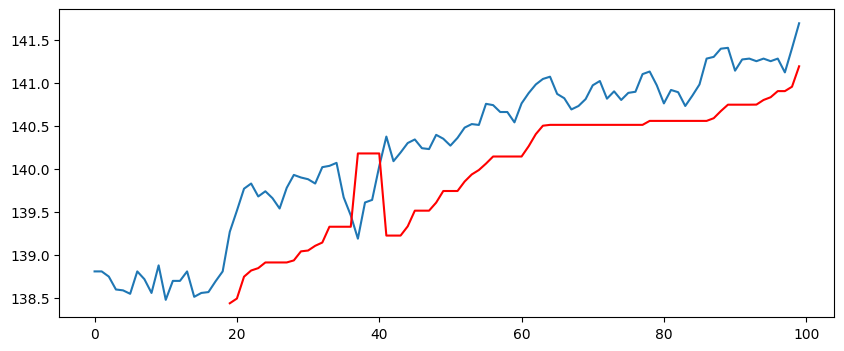

In [11]:
df['Close'].plot(figsize=(10,4))
df['Supertrend'].plot(color='red')